In [ ]:
dataset_url = "https://www.kaggle.com/api/v1/datasets/download/rm1000/lung-cancer-histopathological-images"

datasetdir = "../"
basedir = ""

# install requirements in the parent folder
requirements_path = "../requirements.txt"
!pip install -r {requirements_path}

^C
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [33]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.io.image import decode_jpeg, read_file
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.utils as nn_utils
import seaborn as sns
import os, shutil
from sklearn.model_selection import StratifiedKFold
from torchvision.io import ImageReadMode
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import ImageReadMode
from kymatio.torch import Scattering2D
import glob
from tqdm.auto import tqdm
from zipfile import ZipFile
import json
import cv2

In [34]:
# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import multiprocessing

num_cores = min(multiprocessing.cpu_count(), 4)

In [35]:
ADENOCARCINOMA = "adenocarcinoma"
SQUAMOUS_CELL_CARCINOMA = "squamous_cell_carcinoma"
BENIGN = "benign"

class_0 = BENIGN
class_1 = ADENOCARCINOMA
DATASET_PERCENTAGE = 0.2

In [36]:
def dataset_exists(path=datasetdir + "/dataset", no_files=10000):
    # check if dir exists and contains at least no_files files
    if not os.path.exists(path):
        print(f"Folder not found in {path}")
        return False
    if len(list(glob.iglob(path + "/**", recursive=True))) < no_files:
        print(f"Not enough files in {path}")
        return False
    print(f"Dataset found in {path}")
    return True


if not dataset_exists():
    pass
    with ZipFile(datasetdir + "dataset.zip", "r") as zip_ref:
        zip_ref.extractall()
    # move folders to the right place
    os.makedirs("dataset", exist_ok=True)
    shutil.move(ADENOCARCINOMA, "dataset")
    shutil.move(SQUAMOUS_CELL_CARCINOMA, "dataset")
    shutil.move(BENIGN, "dataset")

Dataset found in ..//dataset


Number of files in benign folder: 5000
Number of files in adenocarcinoma folder: 5000
      filename           class
6341  3338.jpg  adenocarcinoma
2470  2870.jpg          benign
9238  2194.jpg  adenocarcinoma
5176  2761.jpg  adenocarcinoma
1608  3097.jpg          benign
Number of files in the dataset: 2000


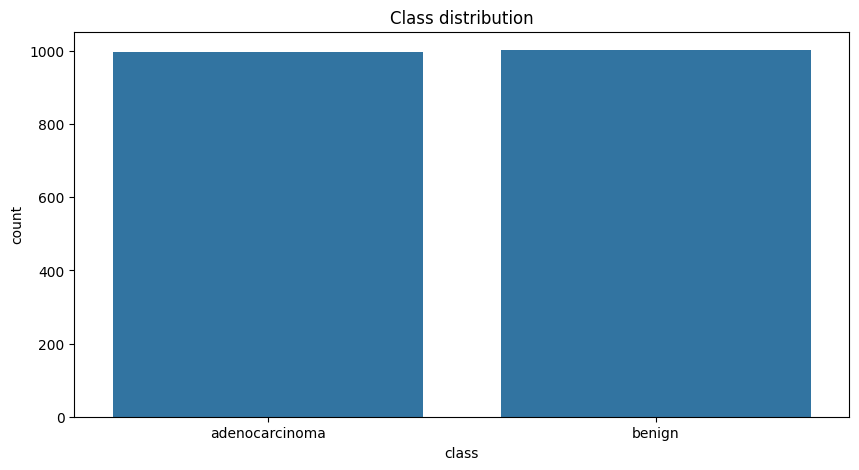

In [37]:
# Creating lists for dataframe construction
allFilesClass0 = os.listdir(f"{datasetdir}dataset/{class_0}")
allFilesClass1 = os.listdir(f"{datasetdir}dataset/{class_1}")

print(f"Number of files in {class_0} folder: {len(allFilesClass0)}")
print(f"Number of files in {class_1} folder: {len(allFilesClass1)}")

df = pd.DataFrame(columns=["filename", "class"])
df["filename"] = allFilesClass0 + allFilesClass1
df["class"] = [class_0] * len(allFilesClass0) + [class_1] * len(allFilesClass1)

# keep DATASETPERCENTAGE data
df = df.sample(frac=DATASET_PERCENTAGE)

print(df.head())
print(f"Number of files in the dataset: {len(df)}")

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="class")
plt.title("Class distribution")
plt.show()

In [38]:
# Performing a stratified k-folds subdivision
KFOLDS = 10
skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=42)
skf.get_n_splits(df["filename"], df["class"])

# Storing indexes to reuse them later
train_indexes = []
val_indexes = []
for train_index, val_index in skf.split(df["filename"], df["class"]):
    train_indexes.append(train_index)
    val_indexes.append(val_index)

train_splits = pd.DataFrame(columns=[f"train_{i}" for i in range(KFOLDS)])
val_splits = pd.DataFrame(columns=[f"val_{i}" for i in range(KFOLDS)])

for i in range(KFOLDS):
    # train_splits[f"train_{i}"] = train_indexes[i]
    # val_splits[f"val_{i}"] = val_indexes[i]
    # move 80% of train indexes to val
    perc = int(0.2 * len(train_indexes[i]))
    train_splits[f"train_{i}"] = train_indexes[i][:perc]
    val_splits[f"val_{i}"] = np.concatenate((train_indexes[i][perc:], val_indexes[i]))


# Saving the splits
train_splits.to_csv(basedir + "train_splits.csv", index=False)
val_splits.to_csv(basedir + "val_splits.csv", index=False)

In [39]:
# recover the splits
train_splits = pd.read_csv(basedir + "train_splits.csv")
val_splits = pd.read_csv(basedir + "val_splits.csv")

In [40]:
TARGET_IMAGE_SIZE = 768

In [41]:
def resize_dataset(df, size):
    new_folder = datasetdir + "dataset_resized"
    os.makedirs(new_folder, exist_ok=True)
    for idx in tqdm(range(len(df))):
        # Read image with OpenCV
        img_path = (
            f"{datasetdir}dataset/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}"
        )
        image = cv2.imread(img_path)
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Resize
        result = cv2.resize(gray, size)
        # Save
        dest_path = f"{new_folder}/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}"
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        cv2.imwrite(dest_path, result)


if not dataset_exists(datasetdir + "dataset_resized"):
    resize_dataset(df, (TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE))

Not enough files in ../dataset_resized


100%|██████████| 2000/2000 [00:07<00:00, 273.45it/s]


In [42]:
class LungCancerDataset(Dataset):
    def __init__(self, df, folder_path, transform=None, cache_size=100):
        self.df = df
        self.folder_path = folder_path
        self.transform = transform
        self.cache_size = cache_size
        self.cache = {}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx in self.cache:
            image, label = self.cache[idx]
        else:
            img_name = self.df.iloc[idx]["filename"]
            img_class = self.df.iloc[idx]["class"]
            img_path = os.path.join(self.folder_path, img_class, img_name)

            # Load and cache image
            # image = Image.open(img_path).convert("RGB")
            # image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255
            data = read_file(img_path)
            # decode rgb
            # image = decode_jpeg(data, device=device).half() / 255
            # decode grayscale
            image = decode_jpeg(data, device=device, mode=ImageReadMode.GRAY) / 255

            label = 1 if img_class == class_1 else 0
            label = torch.tensor(label, dtype=torch.long)

            # Add to cache
            if len(self.cache) < self.cache_size:
                self.cache[idx] = (image, label)

        if self.transform:
            image = self.transform(image)

        return image, label

In [43]:
def calculate_fold_stats(df, train_idx, image_size=TARGET_IMAGE_SIZE, is_gray=True):
    """Calculate mean and std for a specific fold"""

    # Create dataset for train fold
    train_df = df.iloc[train_idx]
    train_dataset = LungCancerDataset(train_df, datasetdir + "dataset_resized")

    # Calculate mean and std
    channels = 1 if is_gray else 3
    channels_sum = torch.zeros(channels, device=device)
    channels_squared_sum = torch.zeros(channels, device=device)
    num_batches = 0

    for data, _ in tqdm(
        DataLoader(
            train_dataset,
            batch_size=32,
        ),
        desc="Calculating dataset statistics",
    ):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [44]:
fold_stats = {}
for fold in range(KFOLDS):
    train_idx = train_splits[f"train_{fold}"].values
    val_idx = val_splits[f"val_{fold}"].values

    # Calculate statistics for this fold
    mean, std = calculate_fold_stats(df, train_idx)
    fold_stats[fold] = {"mean": mean, "std": std}

# Save fold statistics
with open(basedir + "fold_stats.json", "w") as f:
    json.dump(
        {
            k: {"mean": v["mean"].tolist(), "std": v["std"].tolist()}
            for k, v in fold_stats.items()
        },
        f,
    )
    print("Fold statistics saved to fold_stats.json")

Calculating dataset statistics: 100%|██████████| 12/12 [00:00<00:00, 29.95it/s]

Fold statistics saved to fold_stats.json


In [45]:
# load fold statistics
with open(basedir + "fold_stats.json", "r") as f:
    fold_stats = json.load(f)
print(fold_stats)

{'0': {'mean': [0.6469956636428833], 'std': [0.166840061545372]}, '1': {'mean': [0.6459748148918152], 'std': [0.1670152097940445]}, '2': {'mean': [0.6458590030670166], 'std': [0.16660349071025848]}, '3': {'mean': [0.6440173387527466], 'std': [0.1672370433807373]}, '4': {'mean': [0.6439753174781799], 'std': [0.16765281558036804]}, '5': {'mean': [0.6449133157730103], 'std': [0.16896410286426544]}, '6': {'mean': [0.6437848210334778], 'std': [0.16611243784427643]}, '7': {'mean': [0.6449033617973328], 'std': [0.16684435307979584]}, '8': {'mean': [0.6475167274475098], 'std': [0.1675434559583664]}, '9': {'mean': [0.6451447010040283], 'std': [0.16700905561447144]}}


In [46]:
def create_dataloaders(
    df,
    train_idx,
    val_idx,
    mean,
    std,
    batch_size=32,
):
    """Create normalized dataloaders for a specific fold"""

    # Define transforms
    train_transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomResizedCrop(768, scale=(0.8, 1.0)),
            transforms.RandomGrayscale(p=0.1),
            transforms.Normalize(mean=mean, std=std),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.Normalize(mean=mean, std=std),
        ]
    )

    # Create datasets
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_dataset = LungCancerDataset(
        train_df, datasetdir + "dataset_resized", transform=train_transform
    )
    val_dataset = LungCancerDataset(
        val_df, datasetdir + "dataset_resized", transform=val_transform
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

In [47]:
# take the data from the first fold
train_idx = train_splits["train_0"].values
val_idx = val_splits["val_0"].values
mean = fold_stats["0"]["mean"]
std = fold_stats["0"]["std"]

# Create dataloaders with fold-specific normalization
train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)

# check len of train and val loaders
print(f"Train loader length: {len(train_loader)}")
print(f"Val loader length: {len(val_loader)}")

Train loader length: 12
Val loader length: 52


In [48]:
# apply Scattering to an image
scattering = Scattering2D(
    J=5,
    shape=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE),
    backend="torch_skcuda",
    max_order=1,
)
scattering = scattering.to(device)

KeyboardInterrupt: 

In [ ]:
images, labels = next(iter(train_loader))
print(images.shape)

result = scattering(images)
print(result.shape)
""" Output
torch.Size([32, 3, 768, 768])
torch.Size([32, 3, 81, 192, 192])
"""

In [49]:
from kymatio.torch import Scattering2D


# Create a ScatNet
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # Feature extraction
        self.scattering = Scattering2D(
            J=2, shape=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE), backend="torch_skcuda"
        )
        # pool
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        # classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1 * 81, 2),  # J = 2
            # nn.Linear(3 * 1401, 2), # J = 7
        )

    def forward(self, x):
        #print(f"forward: {x.shape}")
        x = self.scattering(x)
        #print(f"scattering: {x.shape}")
        x = self.global_pool(x)
        #print(f"global_pool: {x.shape}")
        x = torch.flatten(x, 1)
        #print(f"flatten: {x.shape}")
        x = self.classifier(x)
        #print(f"classifier: {x.shape}")
        return x


model = ImageClassifier().to(device)

In [50]:
# getting a single image from the batch
images, labels = next(iter(train_loader))
print(f"Labels : {labels}")

print(f"Images shape: {images.shape}")
image = images[0].unsqueeze(0).to(device)
label = labels[0].unsqueeze(0).to(device)

# Forward pass
model.eval()
with torch.inference_mode():
    output = model(image)
    print(output)

# check the model summary
print(
    summary(
        model, input_size=(1, 1, TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE), device=device
    )
)

Labels : tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 0])
Images shape: torch.Size([32, 1, 768, 768])
tensor([[-0.0945, -0.0204]], device='cuda:0')
Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 2]                    --
├─Scattering2D: 1-1                      [1, 1, 81, 192, 192]      --
├─AdaptiveAvgPool2d: 1-2                 [1, 1, 81, 1, 1]          --
├─Sequential: 1-3                        [1, 2]                    --
│    └─Dropout: 2-1                      [1, 81]                   --
│    └─Linear: 2-2                       [1, 2]                    164
Total params: 164
Trainable params: 164
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 2.36
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 2.36


In [51]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    epoch: int,
):

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through DataLoader batches
    for _, (img, label) in enumerate(dataloader):
        # Warmup
        warmup_percent = min(epoch / 3, 1.0)
        current_lr = 5e-4 * warmup_percent
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
        # Send data to target device
        X = img.to(device)
        y = label.to(device)
        y_pred = model(X)
        # Calculate loss
        loss = loss_fn(y_pred, y)
        # Accumulate loss
        train_loss += loss.item()
        # Optimizer zero grad
        optimizer.zero_grad()
        # Loss backward
        loss.backward()
        nn_utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Optimize step with scaler
        optimizer.step()
        # Calculate and accumulate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics for average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [52]:
def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
):
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for _, (img, label) in enumerate(dataloader):
            X = img.to(device)
            y = label.to(device)

            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)

            val_loss += loss.item()
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += (val_pred_labels == y).sum().item() / len(val_pred_labels)

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [53]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 50,
    split: int = 0,
    patience: int = 5,
    min_delta: float = 0.001,
):
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Initialize early stopping variables
    best_val_loss = float("inf")
    epochs_without_improvement = 0

    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=1, eta_min=1e-6
    )
    # Initialize tracking for best model
    best_val = 0

    # Training loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            epoch=epoch,
        )

        val_loss, val_acc = val_step(
            model=model, dataloader=val_dataloader, loss_fn=loss_fn
        )

        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Save best model
        if val_acc > best_val:
            best_val = val_acc
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            checkpoint_name = basedir + "checkpoint_" + str(split) + ".pth"
            torch.save(checkpoint, checkpoint_name)

        # Print training progress
        tqdm.write(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # Store results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    return results

In [54]:
## These lines take a lot of time; you will load the trained model in the following

# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set hyperparameters
NUM_EPOCHS = 50
PATIENCE = 5
MIN_DELTA = 0.001

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# model = model.to(device)

# Train model with early stopping and LR scheduling
model_results = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    split=0,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  2%|▏         | 1/50 [00:32<26:29, 32.43s/it]

Epoch: 1 | train_loss: 0.6770 | train_acc: 0.5911 | val_loss: 0.6786 | val_acc: 0.8576


  4%|▍         | 2/50 [01:06<26:34, 33.23s/it]

Epoch: 2 | train_loss: 0.6834 | train_acc: 0.5182 | val_loss: 0.6782 | val_acc: 0.8552


  6%|▌         | 3/50 [01:40<26:14, 33.51s/it]

Epoch: 3 | train_loss: 0.6792 | train_acc: 0.5964 | val_loss: 0.6774 | val_acc: 0.8606


  8%|▊         | 4/50 [02:12<25:30, 33.27s/it]

Epoch: 4 | train_loss: 0.6817 | train_acc: 0.5443 | val_loss: 0.6763 | val_acc: 0.8570


 10%|█         | 5/50 [02:45<24:52, 33.17s/it]

Epoch: 5 | train_loss: 0.6737 | train_acc: 0.5964 | val_loss: 0.6749 | val_acc: 0.8546


 12%|█▏        | 6/50 [03:19<24:18, 33.15s/it]

Epoch: 6 | train_loss: 0.6742 | train_acc: 0.6120 | val_loss: 0.6735 | val_acc: 0.8468


 14%|█▍        | 7/50 [03:51<23:38, 32.99s/it]

Epoch: 7 | train_loss: 0.6736 | train_acc: 0.5807 | val_loss: 0.6722 | val_acc: 0.8504


 16%|█▌        | 8/50 [04:24<22:59, 32.85s/it]

Epoch: 8 | train_loss: 0.6728 | train_acc: 0.6120 | val_loss: 0.6708 | val_acc: 0.8612


 18%|█▊        | 9/50 [04:56<22:21, 32.72s/it]

Epoch: 9 | train_loss: 0.6789 | train_acc: 0.5469 | val_loss: 0.6696 | val_acc: 0.8564


 20%|██        | 10/50 [05:29<21:54, 32.87s/it]

Epoch: 10 | train_loss: 0.6730 | train_acc: 0.6016 | val_loss: 0.6684 | val_acc: 0.8594


 22%|██▏       | 11/50 [06:03<21:25, 32.97s/it]

Epoch: 11 | train_loss: 0.6687 | train_acc: 0.6016 | val_loss: 0.6672 | val_acc: 0.8594


 24%|██▍       | 12/50 [06:36<20:55, 33.05s/it]

Epoch: 12 | train_loss: 0.6706 | train_acc: 0.5677 | val_loss: 0.6660 | val_acc: 0.8588


 26%|██▌       | 13/50 [07:09<20:23, 33.08s/it]

Epoch: 13 | train_loss: 0.6692 | train_acc: 0.5755 | val_loss: 0.6648 | val_acc: 0.8576


 28%|██▊       | 14/50 [07:42<19:47, 32.98s/it]

Epoch: 14 | train_loss: 0.6738 | train_acc: 0.5495 | val_loss: 0.6636 | val_acc: 0.8552


 30%|███       | 15/50 [08:15<19:15, 33.02s/it]

Epoch: 15 | train_loss: 0.6739 | train_acc: 0.5260 | val_loss: 0.6627 | val_acc: 0.8552


 32%|███▏      | 16/50 [08:48<18:41, 32.99s/it]

Epoch: 16 | train_loss: 0.6704 | train_acc: 0.5599 | val_loss: 0.6617 | val_acc: 0.8600


 34%|███▍      | 17/50 [09:21<18:07, 32.95s/it]

Epoch: 17 | train_loss: 0.6643 | train_acc: 0.5781 | val_loss: 0.6607 | val_acc: 0.8582


 36%|███▌      | 18/50 [09:53<17:28, 32.77s/it]

Epoch: 18 | train_loss: 0.6676 | train_acc: 0.5495 | val_loss: 0.6596 | val_acc: 0.8594


 38%|███▊      | 19/50 [10:26<16:53, 32.70s/it]

Epoch: 19 | train_loss: 0.6681 | train_acc: 0.5417 | val_loss: 0.6586 | val_acc: 0.8576


 40%|████      | 20/50 [10:57<16:13, 32.46s/it]

Epoch: 20 | train_loss: 0.6695 | train_acc: 0.6016 | val_loss: 0.6576 | val_acc: 0.8582


 42%|████▏     | 21/50 [11:29<15:36, 32.28s/it]

Epoch: 21 | train_loss: 0.6648 | train_acc: 0.6120 | val_loss: 0.6566 | val_acc: 0.8594


 44%|████▍     | 22/50 [12:01<15:01, 32.21s/it]

Epoch: 22 | train_loss: 0.6604 | train_acc: 0.5833 | val_loss: 0.6553 | val_acc: 0.8600


 46%|████▌     | 23/50 [12:34<14:34, 32.38s/it]

Epoch: 23 | train_loss: 0.6649 | train_acc: 0.5911 | val_loss: 0.6542 | val_acc: 0.8654


 48%|████▊     | 24/50 [13:07<14:05, 32.51s/it]

Epoch: 24 | train_loss: 0.6686 | train_acc: 0.5885 | val_loss: 0.6533 | val_acc: 0.8606


 50%|█████     | 25/50 [13:39<13:29, 32.37s/it]

Epoch: 25 | train_loss: 0.6557 | train_acc: 0.5964 | val_loss: 0.6524 | val_acc: 0.8606


 52%|█████▏    | 26/50 [14:11<12:53, 32.22s/it]

Epoch: 26 | train_loss: 0.6722 | train_acc: 0.5443 | val_loss: 0.6515 | val_acc: 0.8600


 54%|█████▍    | 27/50 [14:43<12:18, 32.11s/it]

Epoch: 27 | train_loss: 0.6643 | train_acc: 0.5833 | val_loss: 0.6507 | val_acc: 0.8642


 56%|█████▌    | 28/50 [15:15<11:45, 32.06s/it]

Epoch: 28 | train_loss: 0.6572 | train_acc: 0.5990 | val_loss: 0.6496 | val_acc: 0.8606


 58%|█████▊    | 29/50 [15:47<11:12, 32.03s/it]

Epoch: 29 | train_loss: 0.6674 | train_acc: 0.6172 | val_loss: 0.6488 | val_acc: 0.8594


 60%|██████    | 30/50 [16:19<10:42, 32.11s/it]

Epoch: 30 | train_loss: 0.6739 | train_acc: 0.5651 | val_loss: 0.6481 | val_acc: 0.8594


 62%|██████▏   | 31/50 [16:52<10:13, 32.27s/it]

Epoch: 31 | train_loss: 0.6671 | train_acc: 0.5599 | val_loss: 0.6476 | val_acc: 0.8642


 64%|██████▍   | 32/50 [17:24<09:42, 32.36s/it]

Epoch: 32 | train_loss: 0.6628 | train_acc: 0.5521 | val_loss: 0.6469 | val_acc: 0.8648


 66%|██████▌   | 33/50 [17:56<09:08, 32.25s/it]

Epoch: 33 | train_loss: 0.6657 | train_acc: 0.6146 | val_loss: 0.6461 | val_acc: 0.8666


 68%|██████▊   | 34/50 [18:28<08:34, 32.13s/it]

Epoch: 34 | train_loss: 0.6534 | train_acc: 0.5781 | val_loss: 0.6451 | val_acc: 0.8648


 70%|███████   | 35/50 [19:00<08:01, 32.11s/it]

Epoch: 35 | train_loss: 0.6633 | train_acc: 0.5990 | val_loss: 0.6444 | val_acc: 0.8666


 72%|███████▏  | 36/50 [19:33<07:31, 32.24s/it]

Epoch: 36 | train_loss: 0.6692 | train_acc: 0.6016 | val_loss: 0.6437 | val_acc: 0.8666


 74%|███████▍  | 37/50 [20:05<06:59, 32.26s/it]

Epoch: 37 | train_loss: 0.6443 | train_acc: 0.6042 | val_loss: 0.6430 | val_acc: 0.8666


 76%|███████▌  | 38/50 [20:37<06:27, 32.29s/it]

Epoch: 38 | train_loss: 0.6625 | train_acc: 0.6198 | val_loss: 0.6420 | val_acc: 0.8666


 78%|███████▊  | 39/50 [21:10<05:55, 32.30s/it]

Epoch: 39 | train_loss: 0.6562 | train_acc: 0.6250 | val_loss: 0.6411 | val_acc: 0.8660


 80%|████████  | 40/50 [21:42<05:23, 32.31s/it]

Epoch: 40 | train_loss: 0.6661 | train_acc: 0.5964 | val_loss: 0.6403 | val_acc: 0.8612


 82%|████████▏ | 41/50 [22:14<04:50, 32.31s/it]

Epoch: 41 | train_loss: 0.6550 | train_acc: 0.5729 | val_loss: 0.6396 | val_acc: 0.8660


 84%|████████▍ | 42/50 [22:47<04:18, 32.34s/it]

Epoch: 42 | train_loss: 0.6526 | train_acc: 0.6380 | val_loss: 0.6389 | val_acc: 0.8678


 86%|████████▌ | 43/50 [23:19<03:46, 32.33s/it]

Epoch: 43 | train_loss: 0.6606 | train_acc: 0.5938 | val_loss: 0.6379 | val_acc: 0.8666


 88%|████████▊ | 44/50 [23:51<03:13, 32.33s/it]

Epoch: 44 | train_loss: 0.6710 | train_acc: 0.5677 | val_loss: 0.6374 | val_acc: 0.8666


 90%|█████████ | 45/50 [24:24<02:41, 32.33s/it]

Epoch: 45 | train_loss: 0.6680 | train_acc: 0.5964 | val_loss: 0.6370 | val_acc: 0.8666


 92%|█████████▏| 46/50 [24:56<02:09, 32.33s/it]

Epoch: 46 | train_loss: 0.6604 | train_acc: 0.6172 | val_loss: 0.6366 | val_acc: 0.8666


 94%|█████████▍| 47/50 [25:28<01:36, 32.33s/it]

Epoch: 47 | train_loss: 0.6434 | train_acc: 0.5651 | val_loss: 0.6358 | val_acc: 0.8672


 96%|█████████▌| 48/50 [26:01<01:04, 32.33s/it]

Epoch: 48 | train_loss: 0.6661 | train_acc: 0.5599 | val_loss: 0.6351 | val_acc: 0.8666


 98%|█████████▊| 49/50 [26:33<00:32, 32.35s/it]

Epoch: 49 | train_loss: 0.6758 | train_acc: 0.5469 | val_loss: 0.6348 | val_acc: 0.8690


100%|██████████| 50/50 [27:05<00:00, 32.52s/it]

Epoch: 50 | train_loss: 0.6500 | train_acc: 0.5911 | val_loss: 0.6344 | val_acc: 0.8696
Total training time: 1625.872 seconds


In [55]:
## These are the results from the previous step; you will load the results in the following

# Extract train and validation loss and accuracy at each epoch
results = dict(list(model_results.items()))

# Get the loss values of the results dictionary (training and validation)
train_loss = results["train_loss"]
val_loss = results["val_loss"]

# Get the accuracy values of the results dictionary (training and validation)
train_acc = results["train_acc"]
val_acc = results["val_acc"]

# Figure out how many epochs there were
epochs = range(len(results["train_loss"]))
print("epochs: ", epochs)

epochs:  range(0, 50)


In [56]:
## Save results in a csv
results_df = pd.DataFrame(
    columns=["train_loss", "val_loss", "train_acc", "val_acc", "epochs"]
)
results_df["train_loss"] = train_loss
results_df["val_loss"] = val_loss
results_df["train_acc"] = train_acc
results_df["val_acc"] = val_acc
results_df["epochs"] = epochs
results_df_name = basedir + "results_df_" + str(0) + ".csv"
results_df.to_csv(results_df_name)

print("df: ", results_df)

df:      train_loss  val_loss  train_acc   val_acc  epochs
0     0.677010  0.678645   0.591146  0.857572       0
1     0.683444  0.678195   0.518229  0.855168       1
2     0.679160  0.677350   0.596354  0.860577       2
3     0.681666  0.676275   0.544271  0.856971       3
4     0.673719  0.674937   0.596354  0.854567       4
5     0.674240  0.673510   0.611979  0.846755       5
6     0.673617  0.672176   0.580729  0.850361       6
7     0.672758  0.670815   0.611979  0.861178       7
8     0.678923  0.669582   0.546875  0.856370       8
9     0.673013  0.668444   0.601562  0.859375       9
10    0.668703  0.667202   0.601562  0.859375      10
11    0.670550  0.666042   0.567708  0.858774      11
12    0.669250  0.664785   0.575521  0.857572      12
13    0.673792  0.663605   0.549479  0.855168      13
14    0.673888  0.662701   0.526042  0.855168      14
15    0.670378  0.661724   0.559896  0.859976      15
16    0.664343  0.660710   0.578125  0.858173      16
17    0.667644  0.65961

In [57]:
results_from_csv = pd.read_csv(basedir + "results_df_0.csv")

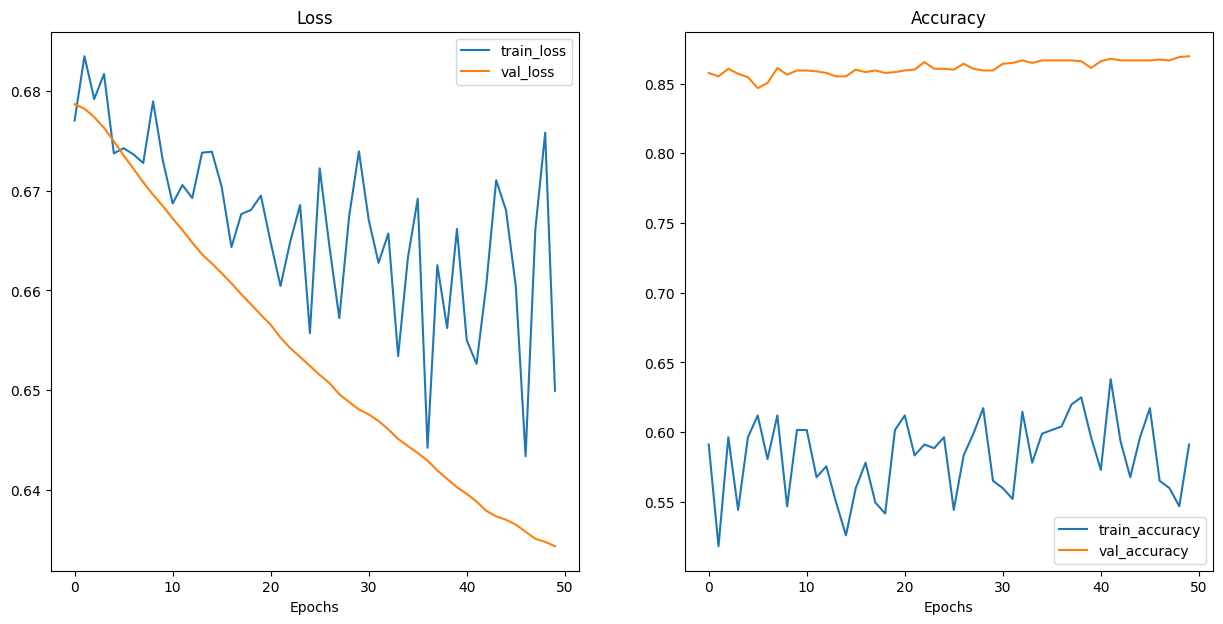

In [58]:
# Setup a plot
plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(results_from_csv["epochs"], results_from_csv["train_loss"], label="train_loss")
plt.plot(results_from_csv["epochs"], results_from_csv["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(
    results_from_csv["epochs"], results_from_csv["train_acc"], label="train_accuracy"
)
plt.plot(results_from_csv["epochs"], results_from_csv["val_acc"], label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [59]:
## You can find the model and result corresponding to each fold in the files inside the directory

# Continue the training and validation of the model for all the other folds
for i in range(1, 10):
    # Keeping the split
    train_str = "train_" + str(i)
    val_str = "val_" + str(i)
    train_idx = train_splits[train_str].values
    val_idx = val_splits[val_str].values
    mean = fold_stats[str(i)]["mean"]
    std = fold_stats[str(i)]["std"]

    # Create dataloaders with fold-specific normalization
    train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)

    # Start the timer
    from timeit import default_timer as timer

    start_time = timer()
    # Train model
    model_results = train(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=NUM_EPOCHS,
        split=i,
    )
    # End the timer and print out how long it took
    end_time = timer()
    print(f"Total training time for split {i}: {end_time-start_time:.3f} seconds")
    # Extract train and validation loss and accuracy at each epoch
    results = dict(list(model_results.items()))
    # Get the loss values of the results dictionary (training and validation)
    train_loss = results["train_loss"]
    val_loss = results["val_loss"]
    # Get the accuracy values of the results dictionary (training and validation)
    train_acc = results["train_acc"]
    val_acc = results["val_acc"]
    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))
    # Save results in a csv
    results_df = pd.DataFrame(
        columns=["train_loss", "val_loss", "train_acc", "val_acc", "epochs"]
    )
    results_df["train_loss"] = train_loss
    results_df["val_loss"] = val_loss
    results_df["train_acc"] = train_acc
    results_df["val_acc"] = val_acc
    results_df["epochs"] = epochs
    results_df_name = basedir + "results_df_" + str(i) + ".csv"
    results_df.to_csv(results_df_name)

  2%|▏         | 1/50 [00:32<26:36, 32.57s/it]

Epoch: 1 | train_loss: 0.6660 | train_acc: 0.5938 | val_loss: 0.6346 | val_acc: 0.8720


  4%|▍         | 2/50 [01:04<25:56, 32.42s/it]

Epoch: 2 | train_loss: 0.6649 | train_acc: 0.5521 | val_loss: 0.6345 | val_acc: 0.8720


  6%|▌         | 3/50 [01:37<25:21, 32.37s/it]

Epoch: 3 | train_loss: 0.6438 | train_acc: 0.6094 | val_loss: 0.6339 | val_acc: 0.8720


  8%|▊         | 4/50 [02:09<24:48, 32.35s/it]

Epoch: 4 | train_loss: 0.6497 | train_acc: 0.6328 | val_loss: 0.6330 | val_acc: 0.8714


 10%|█         | 5/50 [02:41<24:15, 32.34s/it]

Epoch: 5 | train_loss: 0.6647 | train_acc: 0.5990 | val_loss: 0.6324 | val_acc: 0.8714


 12%|█▏        | 6/50 [03:14<23:42, 32.33s/it]

Epoch: 6 | train_loss: 0.6558 | train_acc: 0.5885 | val_loss: 0.6320 | val_acc: 0.8720


 14%|█▍        | 7/50 [03:46<23:10, 32.33s/it]

Epoch: 7 | train_loss: 0.6563 | train_acc: 0.5938 | val_loss: 0.6314 | val_acc: 0.8714


 16%|█▌        | 8/50 [04:18<22:37, 32.33s/it]

Epoch: 8 | train_loss: 0.6610 | train_acc: 0.5885 | val_loss: 0.6308 | val_acc: 0.8720


 18%|█▊        | 9/50 [04:51<22:05, 32.33s/it]

Epoch: 9 | train_loss: 0.6550 | train_acc: 0.6016 | val_loss: 0.6304 | val_acc: 0.8708


 20%|██        | 10/50 [05:23<21:32, 32.32s/it]

Epoch: 10 | train_loss: 0.6528 | train_acc: 0.6484 | val_loss: 0.6298 | val_acc: 0.8714


 22%|██▏       | 11/50 [05:55<21:01, 32.35s/it]

Epoch: 11 | train_loss: 0.6629 | train_acc: 0.5964 | val_loss: 0.6295 | val_acc: 0.8726


 24%|██▍       | 12/50 [06:28<20:28, 32.34s/it]

Epoch: 12 | train_loss: 0.6579 | train_acc: 0.6328 | val_loss: 0.6290 | val_acc: 0.8714


 26%|██▌       | 13/50 [07:00<19:56, 32.33s/it]

Epoch: 13 | train_loss: 0.6454 | train_acc: 0.6250 | val_loss: 0.6282 | val_acc: 0.8720


 28%|██▊       | 14/50 [07:32<19:23, 32.33s/it]

Epoch: 14 | train_loss: 0.6386 | train_acc: 0.6458 | val_loss: 0.6275 | val_acc: 0.8720


 30%|███       | 15/50 [08:05<18:51, 32.33s/it]

Epoch: 15 | train_loss: 0.6607 | train_acc: 0.6016 | val_loss: 0.6268 | val_acc: 0.8714


 32%|███▏      | 16/50 [08:37<18:19, 32.33s/it]

Epoch: 16 | train_loss: 0.6605 | train_acc: 0.6042 | val_loss: 0.6264 | val_acc: 0.8714


 34%|███▍      | 17/50 [09:09<17:46, 32.32s/it]

Epoch: 17 | train_loss: 0.6589 | train_acc: 0.5833 | val_loss: 0.6260 | val_acc: 0.8714


 36%|███▌      | 18/50 [09:42<17:14, 32.32s/it]

Epoch: 18 | train_loss: 0.6429 | train_acc: 0.6276 | val_loss: 0.6254 | val_acc: 0.8714


 38%|███▊      | 19/50 [10:14<16:42, 32.33s/it]

Epoch: 19 | train_loss: 0.6515 | train_acc: 0.6276 | val_loss: 0.6249 | val_acc: 0.8738


 40%|████      | 20/50 [10:46<16:09, 32.33s/it]

Epoch: 20 | train_loss: 0.6402 | train_acc: 0.6302 | val_loss: 0.6241 | val_acc: 0.8732


 42%|████▏     | 21/50 [11:19<15:37, 32.33s/it]

Epoch: 21 | train_loss: 0.6387 | train_acc: 0.6328 | val_loss: 0.6234 | val_acc: 0.8732


 44%|████▍     | 22/50 [11:51<15:04, 32.30s/it]

Epoch: 22 | train_loss: 0.6432 | train_acc: 0.6094 | val_loss: 0.6226 | val_acc: 0.8732


 46%|████▌     | 23/50 [12:23<14:34, 32.39s/it]

Epoch: 23 | train_loss: 0.6400 | train_acc: 0.5990 | val_loss: 0.6219 | val_acc: 0.8720


 48%|████▊     | 24/50 [12:56<14:03, 32.44s/it]

Epoch: 24 | train_loss: 0.6509 | train_acc: 0.6354 | val_loss: 0.6212 | val_acc: 0.8726


 50%|█████     | 25/50 [13:28<13:30, 32.42s/it]

Epoch: 25 | train_loss: 0.6450 | train_acc: 0.5885 | val_loss: 0.6207 | val_acc: 0.8714


 52%|█████▏    | 26/50 [14:01<12:57, 32.41s/it]

Epoch: 26 | train_loss: 0.6583 | train_acc: 0.5677 | val_loss: 0.6203 | val_acc: 0.8714


 54%|█████▍    | 27/50 [14:33<12:24, 32.39s/it]

Epoch: 27 | train_loss: 0.6556 | train_acc: 0.6224 | val_loss: 0.6201 | val_acc: 0.8714


 56%|█████▌    | 28/50 [15:06<11:52, 32.40s/it]

Epoch: 28 | train_loss: 0.6468 | train_acc: 0.6120 | val_loss: 0.6197 | val_acc: 0.8714


 58%|█████▊    | 29/50 [15:38<11:23, 32.54s/it]

Epoch: 29 | train_loss: 0.6445 | train_acc: 0.6432 | val_loss: 0.6191 | val_acc: 0.8714


 60%|██████    | 30/50 [16:11<10:52, 32.63s/it]

Epoch: 30 | train_loss: 0.6598 | train_acc: 0.6406 | val_loss: 0.6186 | val_acc: 0.8714


 62%|██████▏   | 31/50 [16:44<10:18, 32.57s/it]

Epoch: 31 | train_loss: 0.6445 | train_acc: 0.6302 | val_loss: 0.6181 | val_acc: 0.8714


 64%|██████▍   | 32/50 [17:16<09:44, 32.49s/it]

Epoch: 32 | train_loss: 0.6553 | train_acc: 0.6146 | val_loss: 0.6177 | val_acc: 0.8714


 66%|██████▌   | 33/50 [17:48<09:11, 32.44s/it]

Epoch: 33 | train_loss: 0.6403 | train_acc: 0.5964 | val_loss: 0.6174 | val_acc: 0.8732


 68%|██████▊   | 34/50 [18:21<08:38, 32.39s/it]

Epoch: 34 | train_loss: 0.6474 | train_acc: 0.6172 | val_loss: 0.6168 | val_acc: 0.8726


 70%|███████   | 35/50 [18:53<08:05, 32.35s/it]

Epoch: 35 | train_loss: 0.6580 | train_acc: 0.5807 | val_loss: 0.6164 | val_acc: 0.8720


 72%|███████▏  | 36/50 [19:25<07:33, 32.40s/it]

Epoch: 36 | train_loss: 0.6442 | train_acc: 0.6016 | val_loss: 0.6163 | val_acc: 0.8708


 74%|███████▍  | 37/50 [19:58<07:00, 32.38s/it]

Epoch: 37 | train_loss: 0.6389 | train_acc: 0.6276 | val_loss: 0.6156 | val_acc: 0.8714


 76%|███████▌  | 38/50 [20:30<06:28, 32.38s/it]

Epoch: 38 | train_loss: 0.6427 | train_acc: 0.6120 | val_loss: 0.6149 | val_acc: 0.8714


 78%|███████▊  | 39/50 [21:02<05:56, 32.39s/it]

Epoch: 39 | train_loss: 0.6492 | train_acc: 0.5911 | val_loss: 0.6144 | val_acc: 0.8708


 80%|████████  | 40/50 [21:35<05:23, 32.39s/it]

Epoch: 40 | train_loss: 0.6420 | train_acc: 0.6328 | val_loss: 0.6139 | val_acc: 0.8714


 82%|████████▏ | 41/50 [22:07<04:52, 32.46s/it]

Epoch: 41 | train_loss: 0.6567 | train_acc: 0.6198 | val_loss: 0.6136 | val_acc: 0.8714


 84%|████████▍ | 42/50 [22:38<04:15, 31.95s/it]

Epoch: 42 | train_loss: 0.6599 | train_acc: 0.5573 | val_loss: 0.6133 | val_acc: 0.8702


 86%|████████▌ | 43/50 [23:07<03:37, 31.02s/it]

Epoch: 43 | train_loss: 0.6465 | train_acc: 0.6172 | val_loss: 0.6131 | val_acc: 0.8708


 88%|████████▊ | 44/50 [23:36<03:02, 30.37s/it]

Epoch: 44 | train_loss: 0.6568 | train_acc: 0.5833 | val_loss: 0.6127 | val_acc: 0.8708


 90%|█████████ | 45/50 [24:07<02:32, 30.57s/it]

Epoch: 45 | train_loss: 0.6760 | train_acc: 0.5703 | val_loss: 0.6126 | val_acc: 0.8708


 92%|█████████▏| 46/50 [24:40<02:05, 31.34s/it]

Epoch: 46 | train_loss: 0.6373 | train_acc: 0.6094 | val_loss: 0.6125 | val_acc: 0.8690


 94%|█████████▍| 47/50 [25:13<01:35, 31.88s/it]

Epoch: 47 | train_loss: 0.6566 | train_acc: 0.6016 | val_loss: 0.6121 | val_acc: 0.8690


 96%|█████████▌| 48/50 [25:46<01:04, 32.20s/it]

Epoch: 48 | train_loss: 0.6472 | train_acc: 0.6042 | val_loss: 0.6118 | val_acc: 0.8696


 98%|█████████▊| 49/50 [26:18<00:32, 32.22s/it]

Epoch: 49 | train_loss: 0.6588 | train_acc: 0.6068 | val_loss: 0.6115 | val_acc: 0.8696


100%|██████████| 50/50 [26:51<00:00, 32.23s/it]


Epoch: 50 | train_loss: 0.6423 | train_acc: 0.6172 | val_loss: 0.6111 | val_acc: 0.8702
Total training time for split 1: 1611.309 seconds


  2%|▏         | 1/50 [00:32<26:37, 32.60s/it]

Epoch: 1 | train_loss: 0.6453 | train_acc: 0.5938 | val_loss: 0.6109 | val_acc: 0.8684


  4%|▍         | 2/50 [01:04<25:58, 32.47s/it]

Epoch: 2 | train_loss: 0.6712 | train_acc: 0.5938 | val_loss: 0.6110 | val_acc: 0.8684


  6%|▌         | 3/50 [01:37<25:26, 32.47s/it]

Epoch: 3 | train_loss: 0.6314 | train_acc: 0.6484 | val_loss: 0.6109 | val_acc: 0.8678


  8%|▊         | 4/50 [02:10<25:06, 32.74s/it]

Epoch: 4 | train_loss: 0.6428 | train_acc: 0.6172 | val_loss: 0.6105 | val_acc: 0.8678


 10%|█         | 5/50 [02:43<24:37, 32.84s/it]

Epoch: 5 | train_loss: 0.6520 | train_acc: 0.5833 | val_loss: 0.6100 | val_acc: 0.8678


 12%|█▏        | 6/50 [03:16<24:01, 32.75s/it]

Epoch: 6 | train_loss: 0.6587 | train_acc: 0.5755 | val_loss: 0.6098 | val_acc: 0.8678


 14%|█▍        | 7/50 [03:48<23:21, 32.59s/it]

Epoch: 7 | train_loss: 0.6539 | train_acc: 0.6016 | val_loss: 0.6097 | val_acc: 0.8666


 16%|█▌        | 8/50 [04:20<22:46, 32.55s/it]

Epoch: 8 | train_loss: 0.6483 | train_acc: 0.6068 | val_loss: 0.6097 | val_acc: 0.8678


 18%|█▊        | 9/50 [04:53<22:16, 32.59s/it]

Epoch: 9 | train_loss: 0.6390 | train_acc: 0.6172 | val_loss: 0.6092 | val_acc: 0.8672


 20%|██        | 10/50 [05:26<21:43, 32.58s/it]

Epoch: 10 | train_loss: 0.6681 | train_acc: 0.5833 | val_loss: 0.6089 | val_acc: 0.8666


 20%|██        | 10/50 [05:58<23:54, 35.86s/it]


Epoch: 11 | train_loss: 0.6462 | train_acc: 0.5755 | val_loss: 0.6090 | val_acc: 0.8666
Early stopping triggered after 11 epochs
Total training time for split 2: 358.591 seconds


  2%|▏         | 1/50 [00:33<27:10, 33.27s/it]

Epoch: 1 | train_loss: 0.6181 | train_acc: 0.6224 | val_loss: 0.6103 | val_acc: 0.8618


  4%|▍         | 2/50 [01:06<26:33, 33.20s/it]

Epoch: 2 | train_loss: 0.6672 | train_acc: 0.5651 | val_loss: 0.6102 | val_acc: 0.8612


  6%|▌         | 3/50 [01:39<25:59, 33.18s/it]

Epoch: 3 | train_loss: 0.6384 | train_acc: 0.6198 | val_loss: 0.6100 | val_acc: 0.8618


  8%|▊         | 4/50 [02:12<25:27, 33.21s/it]

Epoch: 4 | train_loss: 0.6402 | train_acc: 0.5964 | val_loss: 0.6098 | val_acc: 0.8612


 10%|█         | 5/50 [02:45<24:47, 33.07s/it]

Epoch: 5 | train_loss: 0.6382 | train_acc: 0.6094 | val_loss: 0.6092 | val_acc: 0.8618


 12%|█▏        | 6/50 [03:18<24:05, 32.84s/it]

Epoch: 6 | train_loss: 0.6560 | train_acc: 0.5859 | val_loss: 0.6088 | val_acc: 0.8618


 14%|█▍        | 7/50 [03:51<23:34, 32.91s/it]

Epoch: 7 | train_loss: 0.6489 | train_acc: 0.6146 | val_loss: 0.6086 | val_acc: 0.8618


 16%|█▌        | 8/50 [04:24<23:03, 32.94s/it]

Epoch: 8 | train_loss: 0.6326 | train_acc: 0.6354 | val_loss: 0.6080 | val_acc: 0.8612


 18%|█▊        | 9/50 [04:56<22:28, 32.88s/it]

Epoch: 9 | train_loss: 0.6433 | train_acc: 0.6354 | val_loss: 0.6077 | val_acc: 0.8618


 20%|██        | 10/50 [05:29<21:47, 32.69s/it]

Epoch: 10 | train_loss: 0.6662 | train_acc: 0.5443 | val_loss: 0.6077 | val_acc: 0.8618


 22%|██▏       | 11/50 [06:01<21:15, 32.69s/it]

Epoch: 11 | train_loss: 0.6598 | train_acc: 0.5938 | val_loss: 0.6076 | val_acc: 0.8624


 24%|██▍       | 12/50 [06:33<20:29, 32.35s/it]

Epoch: 12 | train_loss: 0.6478 | train_acc: 0.6354 | val_loss: 0.6075 | val_acc: 0.8630


 24%|██▍       | 12/50 [07:02<22:19, 35.24s/it]


Epoch: 13 | train_loss: 0.6405 | train_acc: 0.6198 | val_loss: 0.6073 | val_acc: 0.8624
Early stopping triggered after 13 epochs
Total training time for split 3: 422.890 seconds


  2%|▏         | 1/50 [00:29<23:43, 29.06s/it]

Epoch: 1 | train_loss: 0.6585 | train_acc: 0.6042 | val_loss: 0.6074 | val_acc: 0.8648


  4%|▍         | 2/50 [01:01<24:50, 31.04s/it]

Epoch: 2 | train_loss: 0.6429 | train_acc: 0.6016 | val_loss: 0.6074 | val_acc: 0.8660


  6%|▌         | 3/50 [01:33<24:31, 31.31s/it]

Epoch: 3 | train_loss: 0.6464 | train_acc: 0.6432 | val_loss: 0.6071 | val_acc: 0.8660


  8%|▊         | 4/50 [02:03<23:50, 31.10s/it]

Epoch: 4 | train_loss: 0.6474 | train_acc: 0.5703 | val_loss: 0.6069 | val_acc: 0.8660


 10%|█         | 5/50 [02:32<22:46, 30.36s/it]

Epoch: 5 | train_loss: 0.6280 | train_acc: 0.6250 | val_loss: 0.6066 | val_acc: 0.8660


 12%|█▏        | 6/50 [03:02<21:57, 29.95s/it]

Epoch: 6 | train_loss: 0.6621 | train_acc: 0.6120 | val_loss: 0.6063 | val_acc: 0.8648


 14%|█▍        | 7/50 [03:33<21:48, 30.42s/it]

Epoch: 7 | train_loss: 0.6519 | train_acc: 0.6016 | val_loss: 0.6063 | val_acc: 0.8636


 16%|█▌        | 8/50 [04:06<21:58, 31.40s/it]

Epoch: 8 | train_loss: 0.6292 | train_acc: 0.6146 | val_loss: 0.6060 | val_acc: 0.8624


 18%|█▊        | 9/50 [04:40<21:52, 32.01s/it]

Epoch: 9 | train_loss: 0.6570 | train_acc: 0.5755 | val_loss: 0.6057 | val_acc: 0.8636


 20%|██        | 10/50 [05:13<21:31, 32.29s/it]

Epoch: 10 | train_loss: 0.6409 | train_acc: 0.5990 | val_loss: 0.6054 | val_acc: 0.8624


 22%|██▏       | 11/50 [05:46<21:07, 32.50s/it]

Epoch: 11 | train_loss: 0.6387 | train_acc: 0.6328 | val_loss: 0.6051 | val_acc: 0.8624


 24%|██▍       | 12/50 [06:18<20:36, 32.54s/it]

Epoch: 12 | train_loss: 0.6327 | train_acc: 0.5964 | val_loss: 0.6048 | val_acc: 0.8624


 26%|██▌       | 13/50 [06:51<20:03, 32.54s/it]

Epoch: 13 | train_loss: 0.6480 | train_acc: 0.5938 | val_loss: 0.6045 | val_acc: 0.8636


 28%|██▊       | 14/50 [07:24<19:38, 32.74s/it]

Epoch: 14 | train_loss: 0.6296 | train_acc: 0.6589 | val_loss: 0.6040 | val_acc: 0.8642


 30%|███       | 15/50 [07:57<19:12, 32.93s/it]

Epoch: 15 | train_loss: 0.6394 | train_acc: 0.6042 | val_loss: 0.6034 | val_acc: 0.8642


 32%|███▏      | 16/50 [08:31<18:43, 33.06s/it]

Epoch: 16 | train_loss: 0.6309 | train_acc: 0.6120 | val_loss: 0.6030 | val_acc: 0.8666


 34%|███▍      | 17/50 [09:04<18:11, 33.08s/it]

Epoch: 17 | train_loss: 0.6384 | train_acc: 0.6224 | val_loss: 0.6026 | val_acc: 0.8660


 36%|███▌      | 18/50 [09:36<17:29, 32.81s/it]

Epoch: 18 | train_loss: 0.6401 | train_acc: 0.6016 | val_loss: 0.6020 | val_acc: 0.8666


 38%|███▊      | 19/50 [10:09<16:57, 32.82s/it]

Epoch: 19 | train_loss: 0.6436 | train_acc: 0.5990 | val_loss: 0.6017 | val_acc: 0.8666


 40%|████      | 20/50 [10:42<16:30, 33.01s/it]

Epoch: 20 | train_loss: 0.6383 | train_acc: 0.5807 | val_loss: 0.6012 | val_acc: 0.8666


 42%|████▏     | 21/50 [11:16<16:00, 33.11s/it]

Epoch: 21 | train_loss: 0.6429 | train_acc: 0.5964 | val_loss: 0.6008 | val_acc: 0.8666


 44%|████▍     | 22/50 [11:49<15:29, 33.20s/it]

Epoch: 22 | train_loss: 0.6619 | train_acc: 0.5781 | val_loss: 0.6008 | val_acc: 0.8672


 46%|████▌     | 23/50 [12:23<14:58, 33.27s/it]

Epoch: 23 | train_loss: 0.6513 | train_acc: 0.6094 | val_loss: 0.6007 | val_acc: 0.8666


 48%|████▊     | 24/50 [12:56<14:25, 33.28s/it]

Epoch: 24 | train_loss: 0.6373 | train_acc: 0.5703 | val_loss: 0.6005 | val_acc: 0.8666


 50%|█████     | 25/50 [13:29<13:51, 33.27s/it]

Epoch: 25 | train_loss: 0.6288 | train_acc: 0.6589 | val_loss: 0.6002 | val_acc: 0.8672


 52%|█████▏    | 26/50 [14:02<13:16, 33.18s/it]

Epoch: 26 | train_loss: 0.6389 | train_acc: 0.6172 | val_loss: 0.5998 | val_acc: 0.8672


 54%|█████▍    | 27/50 [14:35<12:41, 33.11s/it]

Epoch: 27 | train_loss: 0.6704 | train_acc: 0.5833 | val_loss: 0.5998 | val_acc: 0.8666


 56%|█████▌    | 28/50 [15:08<12:08, 33.09s/it]

Epoch: 28 | train_loss: 0.6436 | train_acc: 0.6302 | val_loss: 0.5999 | val_acc: 0.8678


 56%|█████▌    | 28/50 [15:41<12:19, 33.63s/it]


Epoch: 29 | train_loss: 0.6558 | train_acc: 0.5859 | val_loss: 0.5998 | val_acc: 0.8672
Early stopping triggered after 29 epochs
Total training time for split 4: 941.648 seconds


  2%|▏         | 1/50 [00:33<27:30, 33.68s/it]

Epoch: 1 | train_loss: 0.6510 | train_acc: 0.5651 | val_loss: 0.6003 | val_acc: 0.8672


  4%|▍         | 2/50 [01:07<26:50, 33.56s/it]

Epoch: 2 | train_loss: 0.6512 | train_acc: 0.6146 | val_loss: 0.6003 | val_acc: 0.8678


  6%|▌         | 3/50 [01:40<26:09, 33.39s/it]

Epoch: 3 | train_loss: 0.6067 | train_acc: 0.6615 | val_loss: 0.6000 | val_acc: 0.8672


  8%|▊         | 4/50 [02:13<25:30, 33.26s/it]

Epoch: 4 | train_loss: 0.6301 | train_acc: 0.6536 | val_loss: 0.5995 | val_acc: 0.8672


 10%|█         | 5/50 [02:46<24:58, 33.31s/it]

Epoch: 5 | train_loss: 0.6271 | train_acc: 0.6562 | val_loss: 0.5989 | val_acc: 0.8672


 12%|█▏        | 6/50 [03:20<24:26, 33.34s/it]

Epoch: 6 | train_loss: 0.6579 | train_acc: 0.5885 | val_loss: 0.5988 | val_acc: 0.8666


 14%|█▍        | 7/50 [03:53<23:54, 33.36s/it]

Epoch: 7 | train_loss: 0.6275 | train_acc: 0.6458 | val_loss: 0.5988 | val_acc: 0.8660


 16%|█▌        | 8/50 [04:26<23:20, 33.34s/it]

Epoch: 8 | train_loss: 0.6417 | train_acc: 0.6198 | val_loss: 0.5985 | val_acc: 0.8654


 18%|█▊        | 9/50 [04:59<22:43, 33.26s/it]

Epoch: 9 | train_loss: 0.6134 | train_acc: 0.6719 | val_loss: 0.5981 | val_acc: 0.8660


 20%|██        | 10/50 [05:33<22:07, 33.19s/it]

Epoch: 10 | train_loss: 0.6324 | train_acc: 0.6406 | val_loss: 0.5976 | val_acc: 0.8660


 22%|██▏       | 11/50 [06:06<21:33, 33.16s/it]

Epoch: 11 | train_loss: 0.6444 | train_acc: 0.6146 | val_loss: 0.5973 | val_acc: 0.8654


 24%|██▍       | 12/50 [06:39<21:04, 33.26s/it]

Epoch: 12 | train_loss: 0.6713 | train_acc: 0.5417 | val_loss: 0.5973 | val_acc: 0.8654


 26%|██▌       | 13/50 [07:13<20:35, 33.38s/it]

Epoch: 13 | train_loss: 0.6420 | train_acc: 0.6484 | val_loss: 0.5976 | val_acc: 0.8654


 28%|██▊       | 14/50 [07:46<20:02, 33.40s/it]

Epoch: 14 | train_loss: 0.6311 | train_acc: 0.6432 | val_loss: 0.5973 | val_acc: 0.8618


 28%|██▊       | 14/50 [08:19<21:23, 35.66s/it]


Epoch: 15 | train_loss: 0.6228 | train_acc: 0.6432 | val_loss: 0.5971 | val_acc: 0.8642
Early stopping triggered after 15 epochs
Total training time for split 5: 499.203 seconds


  2%|▏         | 1/50 [00:32<26:54, 32.94s/it]

Epoch: 1 | train_loss: 0.6351 | train_acc: 0.6224 | val_loss: 0.5956 | val_acc: 0.8594


  4%|▍         | 2/50 [01:05<26:13, 32.79s/it]

Epoch: 2 | train_loss: 0.6428 | train_acc: 0.5990 | val_loss: 0.5955 | val_acc: 0.8594


  6%|▌         | 3/50 [01:38<25:36, 32.69s/it]

Epoch: 3 | train_loss: 0.6511 | train_acc: 0.5990 | val_loss: 0.5954 | val_acc: 0.8594


  8%|▊         | 4/50 [02:10<24:59, 32.60s/it]

Epoch: 4 | train_loss: 0.6473 | train_acc: 0.6068 | val_loss: 0.5956 | val_acc: 0.8594


 10%|█         | 5/50 [02:42<24:17, 32.38s/it]

Epoch: 5 | train_loss: 0.6432 | train_acc: 0.6172 | val_loss: 0.5952 | val_acc: 0.8588


 10%|█         | 5/50 [03:15<29:17, 39.06s/it]


Epoch: 6 | train_loss: 0.6393 | train_acc: 0.5911 | val_loss: 0.5951 | val_acc: 0.8594
Early stopping triggered after 6 epochs
Total training time for split 6: 195.314 seconds


  2%|▏         | 1/50 [00:32<26:54, 32.96s/it]

Epoch: 1 | train_loss: 0.6526 | train_acc: 0.5599 | val_loss: 0.5946 | val_acc: 0.8666


  4%|▍         | 2/50 [01:05<26:09, 32.69s/it]

Epoch: 2 | train_loss: 0.6340 | train_acc: 0.6094 | val_loss: 0.5946 | val_acc: 0.8672


  6%|▌         | 3/50 [01:37<25:19, 32.34s/it]

Epoch: 3 | train_loss: 0.6449 | train_acc: 0.6328 | val_loss: 0.5944 | val_acc: 0.8672


  8%|▊         | 4/50 [02:09<24:39, 32.16s/it]

Epoch: 4 | train_loss: 0.6493 | train_acc: 0.6172 | val_loss: 0.5945 | val_acc: 0.8666


 10%|█         | 5/50 [02:41<24:02, 32.05s/it]

Epoch: 5 | train_loss: 0.6420 | train_acc: 0.6328 | val_loss: 0.5946 | val_acc: 0.8648


 10%|█         | 5/50 [03:12<28:56, 38.59s/it]


Epoch: 6 | train_loss: 0.6414 | train_acc: 0.6224 | val_loss: 0.5946 | val_acc: 0.8642
Early stopping triggered after 6 epochs
Total training time for split 7: 192.967 seconds


  2%|▏         | 1/50 [00:32<26:19, 32.23s/it]

Epoch: 1 | train_loss: 0.6523 | train_acc: 0.5703 | val_loss: 0.5951 | val_acc: 0.8660


  4%|▍         | 2/50 [01:04<25:59, 32.49s/it]

Epoch: 2 | train_loss: 0.6284 | train_acc: 0.6224 | val_loss: 0.5951 | val_acc: 0.8660


  6%|▌         | 3/50 [01:37<25:30, 32.57s/it]

Epoch: 3 | train_loss: 0.6433 | train_acc: 0.6224 | val_loss: 0.5950 | val_acc: 0.8654


  8%|▊         | 4/50 [02:09<24:51, 32.43s/it]

Epoch: 4 | train_loss: 0.6714 | train_acc: 0.5573 | val_loss: 0.5951 | val_acc: 0.8642


 10%|█         | 5/50 [02:41<24:10, 32.24s/it]

Epoch: 5 | train_loss: 0.6507 | train_acc: 0.6120 | val_loss: 0.5953 | val_acc: 0.8618


 10%|█         | 5/50 [03:13<29:02, 38.73s/it]


Epoch: 6 | train_loss: 0.6813 | train_acc: 0.5833 | val_loss: 0.5957 | val_acc: 0.8606
Early stopping triggered after 6 epochs
Total training time for split 8: 193.631 seconds


  2%|▏         | 1/50 [00:32<26:51, 32.90s/it]

Epoch: 1 | train_loss: 0.6311 | train_acc: 0.6276 | val_loss: 0.5949 | val_acc: 0.8636


  4%|▍         | 2/50 [01:05<26:13, 32.79s/it]

Epoch: 2 | train_loss: 0.6368 | train_acc: 0.6172 | val_loss: 0.5949 | val_acc: 0.8636


  6%|▌         | 3/50 [01:38<25:32, 32.62s/it]

Epoch: 3 | train_loss: 0.6241 | train_acc: 0.6250 | val_loss: 0.5946 | val_acc: 0.8636


  8%|▊         | 4/50 [02:09<24:46, 32.32s/it]

Epoch: 4 | train_loss: 0.6271 | train_acc: 0.6146 | val_loss: 0.5940 | val_acc: 0.8642


 10%|█         | 5/50 [02:38<23:16, 31.04s/it]

Epoch: 5 | train_loss: 0.6641 | train_acc: 0.5729 | val_loss: 0.5939 | val_acc: 0.8636


 10%|█         | 5/50 [03:07<28:06, 37.49s/it]

Epoch: 6 | train_loss: 0.6688 | train_acc: 0.5729 | val_loss: 0.5943 | val_acc: 0.8636
Early stopping triggered after 6 epochs
Total training time for split 9: 187.438 seconds


In [60]:
# Loading the checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device(device))
    model = ImageClassifier()
    model.load_state_dict(checkpoint["state_dict"])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

In [63]:
def f1_score(y_true, y_pred):
    tp = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    # Avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Avoid division by zero
    f1 = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) != 0
        else 0
    )
    return f1


def accuracy_score(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    accuracy = correct / len(y_true)
    return accuracy


def compute_metrics(model, dataloader):
    model.eval()
    y_true = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            y_pred_class = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            y_true = np.concatenate((y_true, labels.cpu().numpy()))
            y_pred = np.concatenate((y_pred, y_pred_class.cpu().numpy()))

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, f1


accuracies = []
f1_scores = []
# Iterate through all folds (0-9)
for i in range(10):
    model = load_checkpoint(basedir + "checkpoint_" + str(i) + ".pth")
    model.to(device)
    train_str = "train_" + str(i)
    val_str = "val_" + str(i)
    train_idx = train_splits[train_str].values
    val_idx = val_splits[val_str].values
    mean = fold_stats[str(i)]["mean"]
    std = fold_stats[str(i)]["std"]
    _, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)
    accuracy, f1 = compute_metrics(model, val_loader)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    print(f"Accuracy for split {i}: {accuracy}")
    print(f"F1 Score for split {i}: {f1}")


mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean F1 Score: {mean_f1_score}")

Accuracy for split 0: 0.8713414634146341
F1 Score for split 0: 0.8808582721626201
Accuracy for split 1: 0.873780487804878
F1 Score for split 1: 0.8842929010620458
Accuracy for split 2: 0.8682926829268293
F1 Score for split 2: 0.8798665183537263
Accuracy for split 3: 0.8646341463414634
F1 Score for split 3: 0.877887788778878
Accuracy for split 4: 0.8676829268292683
F1 Score for split 4: 0.8803088803088803
Accuracy for split 5: 0.8658536585365854
F1 Score for split 5: 0.8785871964679911
Accuracy for split 6: 0.8628048780487805
F1 Score for split 6: 0.8764415156507414
Accuracy for split 7: 0.8652439024390244
F1 Score for split 7: 0.8781025923883067
Accuracy for split 8: 0.8676829268292683
F1 Score for split 8: 0.8797783933518005
Accuracy for split 9: 0.8621951219512195
F1 Score for split 9: 0.876772082878953
Mean Accuracy: 0.866951219512195
Mean F1 Score: 0.8792896141403943
